# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [26]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

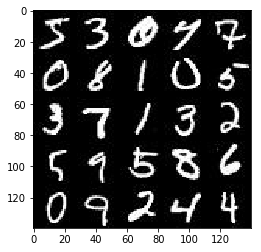

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

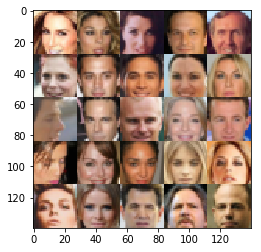

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [30]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.3 * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.3 * x2, x2)
 
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.3 * x3, x3)

        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, (7*7*512))
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.3 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.3 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.3 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)

    d_out_real, d_logits_real =  discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake =  discriminator(g_model, reuse=True)

    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_real, labels = tf.ones_like(d_out_real)* (1 - 0.1)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.zeros_like(d_out_real)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, 0.5)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                print('step # {}'.format(steps))
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

step # 1
step # 2
step # 3
step # 4
step # 5
step # 6
step # 7
step # 8
step # 9
step # 10
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.5923
step # 11
step # 12
step # 13
step # 14
step # 15
step # 16
step # 17
step # 18
step # 19
step # 20
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 1.0034
step # 21
step # 22
step # 23
step # 24
step # 25
step # 26
step # 27
step # 28
step # 29
step # 30
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.8980
step # 31
step # 32
step # 33
step # 34
step # 35
step # 36
step # 37
step # 38
step # 39
step # 40
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 1.1883
step # 41
step # 42
step # 43
step # 44
step # 45
step # 46
step # 47
step # 48
step # 49
step # 50
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.5856
step # 51
step # 52
step # 53
step # 54
step # 55
step # 56
step # 57
step # 58
step # 59
step # 60
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.8433
step # 61
ste

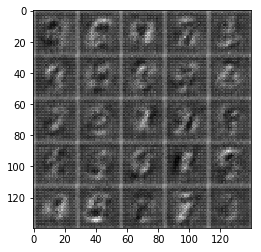

step # 101
step # 102
step # 103
step # 104
step # 105
step # 106
step # 107
step # 108
step # 109
step # 110
Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 0.9497
step # 111
step # 112
step # 113
step # 114
step # 115
step # 116
step # 117
step # 118
step # 119
step # 120
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.6624
step # 121
step # 122
step # 123
step # 124
step # 125
step # 126
step # 127
step # 128
step # 129
step # 130
Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 1.5600
step # 131
step # 132
step # 133
step # 134
step # 135
step # 136
step # 137
step # 138
step # 139
step # 140
Epoch 1/2... Discriminator Loss: 0.8022... Generator Loss: 1.2178
step # 141
step # 142
step # 143
step # 144
step # 145
step # 146
step # 147
step # 148
step # 149
step # 150
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 2.0581
step # 151
step # 152
step # 153
step # 154
step # 155
step # 156
step # 157
step # 158
step # 159
step # 160
Epoch 1/2.

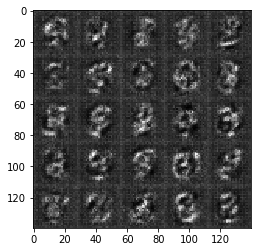

step # 201
step # 202
step # 203
step # 204
step # 205
step # 206
step # 207
step # 208
step # 209
step # 210
Epoch 1/2... Discriminator Loss: 0.4004... Generator Loss: 3.2114
step # 211
step # 212
step # 213
step # 214
step # 215
step # 216
step # 217
step # 218
step # 219
step # 220
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.5521
step # 221
step # 222
step # 223
step # 224
step # 225
step # 226
step # 227
step # 228
step # 229
step # 230
Epoch 1/2... Discriminator Loss: 0.4725... Generator Loss: 2.3654
step # 231
step # 232
step # 233
step # 234
step # 235
step # 236
step # 237
step # 238
step # 239
step # 240
Epoch 1/2... Discriminator Loss: 0.7532... Generator Loss: 1.2551
step # 241
step # 242
step # 243
step # 244
step # 245
step # 246
step # 247
step # 248
step # 249
step # 250
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.0577
step # 251
step # 252
step # 253
step # 254
step # 255
step # 256
step # 257
step # 258
step # 259
step # 260
Epoch 1/2.

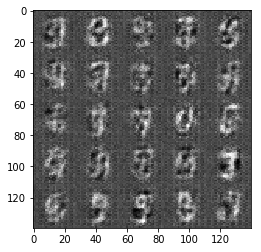

step # 301
step # 302
step # 303
step # 304
step # 305
step # 306
step # 307
step # 308
step # 309
step # 310
Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 3.7870
step # 311
step # 312
step # 313
step # 314
step # 315
step # 316
step # 317
step # 318
step # 319
step # 320
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 1.6430
step # 321
step # 322
step # 323
step # 324
step # 325
step # 326
step # 327
step # 328
step # 329
step # 330
Epoch 1/2... Discriminator Loss: 0.5824... Generator Loss: 2.3970
step # 331
step # 332
step # 333
step # 334
step # 335
step # 336
step # 337
step # 338
step # 339
step # 340
Epoch 1/2... Discriminator Loss: 0.6663... Generator Loss: 3.7877
step # 341
step # 342
step # 343
step # 344
step # 345
step # 346
step # 347
step # 348
step # 349
step # 350
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.7023
step # 351
step # 352
step # 353
step # 354
step # 355
step # 356
step # 357
step # 358
step # 359
step # 360
Epoch 1/2.

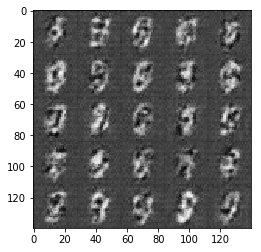

step # 401
step # 402
step # 403
step # 404
step # 405
step # 406
step # 407
step # 408
step # 409
step # 410
Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 2.9794
step # 411
step # 412
step # 413
step # 414
step # 415
step # 416
step # 417
step # 418
step # 419
step # 420
Epoch 1/2... Discriminator Loss: 0.4712... Generator Loss: 2.5020
step # 421
step # 422
step # 423
step # 424
step # 425
step # 426
step # 427
step # 428
step # 429
step # 430
Epoch 1/2... Discriminator Loss: 0.4910... Generator Loss: 2.2261
step # 431
step # 432
step # 433
step # 434
step # 435
step # 436
step # 437
step # 438
step # 439
step # 440
Epoch 1/2... Discriminator Loss: 0.4877... Generator Loss: 2.4497
step # 441
step # 442
step # 443
step # 444
step # 445
step # 446
step # 447
step # 448
step # 449
step # 450
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 2.7301
step # 451
step # 452
step # 453
step # 454
step # 455
step # 456
step # 457
step # 458
step # 459
step # 460
Epoch 1/2.

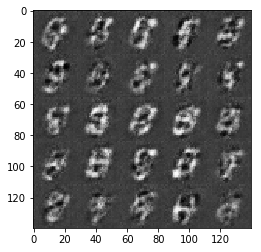

step # 501
step # 502
step # 503
step # 504
step # 505
step # 506
step # 507
step # 508
step # 509
step # 510
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 3.0214
step # 511
step # 512
step # 513
step # 514
step # 515
step # 516
step # 517
step # 518
step # 519
step # 520
Epoch 1/2... Discriminator Loss: 0.5171... Generator Loss: 2.1099
step # 521
step # 522
step # 523
step # 524
step # 525
step # 526
step # 527
step # 528
step # 529
step # 530
Epoch 1/2... Discriminator Loss: 0.5796... Generator Loss: 3.6377
step # 531
step # 532
step # 533
step # 534
step # 535
step # 536
step # 537
step # 538
step # 539
step # 540
Epoch 1/2... Discriminator Loss: 0.4248... Generator Loss: 3.1673
step # 541
step # 542
step # 543
step # 544
step # 545
step # 546
step # 547
step # 548
step # 549
step # 550
Epoch 1/2... Discriminator Loss: 0.4390... Generator Loss: 2.9778
step # 551
step # 552
step # 553
step # 554
step # 555
step # 556
step # 557
step # 558
step # 559
step # 560
Epoch 1/2.

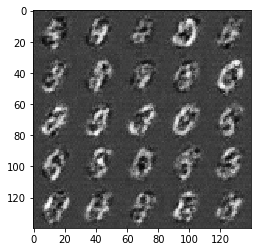

step # 601
step # 602
step # 603
step # 604
step # 605
step # 606
step # 607
step # 608
step # 609
step # 610
Epoch 1/2... Discriminator Loss: 0.5691... Generator Loss: 1.9226
step # 611
step # 612
step # 613
step # 614
step # 615
step # 616
step # 617
step # 618
step # 619
step # 620
Epoch 1/2... Discriminator Loss: 0.4019... Generator Loss: 3.0981
step # 621
step # 622
step # 623
step # 624
step # 625
step # 626
step # 627
step # 628
step # 629
step # 630
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 2.2922
step # 631
step # 632
step # 633
step # 634
step # 635
step # 636
step # 637
step # 638
step # 639
step # 640
Epoch 1/2... Discriminator Loss: 0.3902... Generator Loss: 3.3587
step # 641
step # 642
step # 643
step # 644
step # 645
step # 646
step # 647
step # 648
step # 649
step # 650
Epoch 1/2... Discriminator Loss: 0.5150... Generator Loss: 1.9700
step # 651
step # 652
step # 653
step # 654
step # 655
step # 656
step # 657
step # 658
step # 659
step # 660
Epoch 1/2.

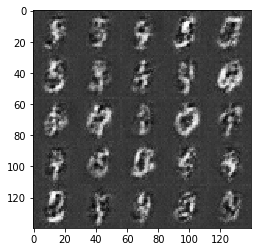

step # 701
step # 702
step # 703
step # 704
step # 705
step # 706
step # 707
step # 708
step # 709
step # 710
Epoch 1/2... Discriminator Loss: 0.4395... Generator Loss: 2.5836
step # 711
step # 712
step # 713
step # 714
step # 715
step # 716
step # 717
step # 718
step # 719
step # 720
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 3.2990
step # 721
step # 722
step # 723
step # 724
step # 725
step # 726
step # 727
step # 728
step # 729
step # 730
Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 3.4703
step # 731
step # 732
step # 733
step # 734
step # 735
step # 736
step # 737
step # 738
step # 739
step # 740
Epoch 1/2... Discriminator Loss: 0.3705... Generator Loss: 4.1513
step # 741
step # 742
step # 743
step # 744
step # 745
step # 746
step # 747
step # 748
step # 749
step # 750
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 3.9234
step # 751
step # 752
step # 753
step # 754
step # 755
step # 756
step # 757
step # 758
step # 759
step # 760
Epoch 1/2.

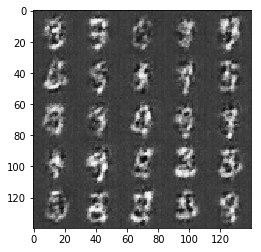

step # 801
step # 802
step # 803
step # 804
step # 805
step # 806
step # 807
step # 808
step # 809
step # 810
Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 3.4977
step # 811
step # 812
step # 813
step # 814
step # 815
step # 816
step # 817
step # 818
step # 819
step # 820
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 3.4789
step # 821
step # 822
step # 823
step # 824
step # 825
step # 826
step # 827
step # 828
step # 829
step # 830
Epoch 1/2... Discriminator Loss: 0.3910... Generator Loss: 4.0110
step # 831
step # 832
step # 833
step # 834
step # 835
step # 836
step # 837
step # 838
step # 839
step # 840
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 4.6124
step # 841
step # 842
step # 843
step # 844
step # 845
step # 846
step # 847
step # 848
step # 849
step # 850
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 4.2735
step # 851
step # 852
step # 853
step # 854
step # 855
step # 856
step # 857
step # 858
step # 859
step # 860
Epoch 1/2.

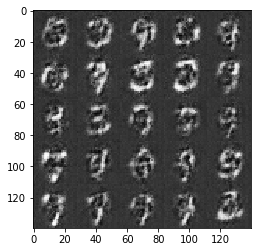

step # 901
step # 902
step # 903
step # 904
step # 905
step # 906
step # 907
step # 908
step # 909
step # 910
Epoch 1/2... Discriminator Loss: 0.3917... Generator Loss: 3.0639
step # 911
step # 912
step # 913
step # 914
step # 915
step # 916
step # 917
step # 918
step # 919
step # 920
Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 3.7100
step # 921
step # 922
step # 923
step # 924
step # 925
step # 926
step # 927
step # 928
step # 929
step # 930
Epoch 1/2... Discriminator Loss: 0.4134... Generator Loss: 2.7928
step # 931
step # 932
step # 933
step # 934
step # 935
step # 936
step # 937
step # 938
step # 939
step # 940
Epoch 2/2... Discriminator Loss: 0.3660... Generator Loss: 4.0009
step # 941
step # 942
step # 943
step # 944
step # 945
step # 946
step # 947
step # 948
step # 949
step # 950
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 3.0046
step # 951
step # 952
step # 953
step # 954
step # 955
step # 956
step # 957
step # 958
step # 959
step # 960
Epoch 2/2.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.